# 数据挖掘实验Logistic

## 导入需要的包

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # 画图
import copy # 用于拷贝数据副本

plt.rcParams['axes.unicode_minus']=False # 显示负数
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文

from sklearn.model_selection import train_test_split # 划分训练集和测试集的包
from sklearn.metrics import confusion_matrix, classification_report # 画混淆矩阵和输出分类评价指标的包
from sklearn.metrics import accuracy_score # 计算精确度的包
import seaborn as sns # 将混淆矩阵可视化的包

## 自定义逻辑回归类

逻辑回归又称对数几率回归. 虽然它的名字是回归,但实际确实一种分类算法, 主要适用于二分类任务, 若想用逻辑回归处理多分类问题需要做一定的变形.\par
        	在线性回归中,预测目标y是连续的,且可以写成样本每一个特征的线性加权形式:
        	\begin{equation}
        		y = f(x) = w_1x_1 + \cdots + w_dx_d + w_0 = w^Tx,\tag{1}
        	\end{equation}
        	其中$\omega$为参数向量,$d$为特征维度.现在假设解决的是二分类问题,即预测目标y此时的取值范围为${-1, 1}$. 显然,线性回归不能直接求解,但使用广义线性模型,将连续的y值映射到一个单调可微的函数中,即可求解上述问题.逻辑回归采用的方法是引入一个Sigmoid函数(常称为对数几率函数或逻辑斯蒂函数):
        	\begin{equation}
        		\sigma(x) = \frac{1}{1 + e^{-x}},\tag{2}
        	\end{equation}
        	对应的函数图像如下图所示.
          ![Logistic函数](./Logistics_function.png)
        	当输入的x很大或者很小时,该函数以接近于0或1的值输出,且$\sigma(0)=0.5$.对数几率函数的导数可以用对应的函数值表示,即$\sigma'(x) = \sigma(x)(1-\sigma(x))$.
        	将式1带入2中,得到
        	\begin{equation}
        		y = \frac{1}{1 + e^{-\omega^Tx}}, \tag{3}
        	\end{equation}
        	若将y视为类后验概率$p(y=1|x)$, 那么样本$x_i$为正类的概率为:
        	\begin{equation}
        		p(y_i=1|x_i) = \sigma(f(x_i)) = \frac{1}{1 + e^{-\omega^Tx_i}}, \tag{4}
        	\end{equation}
        	则样本$x_i$的类别为负类(y = -1)的概率为:
        	\begin{equation}
        		p(y_i=-1|x_i) = 1 - p(y_i=1|x_i) = \frac{1}{1 + e^{\omega^Tx_i}}, \tag{5}
        	\end{equation}
        	对比4和5,考虑到$y_i\in \{1, -1\}$, 则将两式统一写为:
        	\begin{equation}
        		p(y_i|x_i) = \frac{1}{1 + e^{-y_i\omega^Tx_i}}, \tag{6}
        	\end{equation}
        	假设训练集为$D = {(x_1, y_1), (x_2, y_2), \cdots, (x_n, y_n)}$.那么可以用最大似然法来估计参数$\omega$.利用式6,我们可以写出训练集的似然函数
        	\begin{equation}
        		L(\omega) = \prod_{i=1}^{n}p(y_i|x_i), \tag{7}
        	\end{equation}
        	对7取对数,得到了训练集的负对数似然为
        	\begin{equation}
        		NLL(\omega) = -ln\prod_{i=1}^np(y_i|x_i) = -\sum_{i=1}^{n}lnp(y_i|x_i), \tag{8}
        	\end{equation}
        	现在,我们的目标变为求解出$\omega$,使得8最小.求目标函数最小值常用的方法有最小二乘法和梯度下降法,本文使用梯度下降法求解,即使用如下公式不断更新参数:
        	\begin{equation}
        		\omega \leftarrow \omega - \eta\nabla NLL(\omega).\tag{9}
        	\end{equation}
        	其中$\eta$为学习率,$\nabla NLL(\omega)$为目标函数对于参数$\omega$的梯度.可见,只要能够计算梯度,就能够计算逻辑回归的参数.记$f_i(w) = y_i\omega^Tx_i$,利用复合函数求导的链式法则,有:
        	\begin{equation}
        		\begin{split}
        			\nabla NLL(\omega) &= -\sum_{i=1}^{n}\frac{\partial lnp(y_i|x_i)}{\partial\omega} \\
        			&= -\sum_{i=1}^{n}\frac{1}{p(y_i|x_i)}\frac{\partial p(y_i|x_i)}{\partial\omega} \\
        			&= -\sum_{i=1}^n\frac{1}{p(y_i|x_i)}\frac{\partial p(y_i|x_i)}{\partial f_i(\omega)}\frac{\partial f_i(\omega)}{\partial\omega}
        		\end{split}
                \tag{10}
        	\end{equation}
        	观察6,我们可以看到$p(y_i|x_i) = \sigma(f_i(\omega))$,所以
        	\begin{equation}
        		\frac{\partial p(y_i|x_i)}{\partial f_i(\omega)} = p(y_i|x_i)(1-p(y_i|x_i))
        	\tag{11}
        	\end{equation}
         	因为$f_i(\omega) = y_i\omega^Tx_i$, 容易得到
         	\begin{equation}
         		\frac{\partial f_i(\omega)}{\partial\omega} = \frac{\partial y_i\omega^Tx_i}{\partial\omega} = y_ix_i.
         	\tag{12}
         	\end{equation}
         	将11和12带入式10,我们得到
         	\begin{equation}
         		\nabla NLL(\omega) = -\sum_{i=1}^n(1-\sigma(y_i\omega^Tx_i))y_ix_i
         	\tag{13}
         	\end{equation}
         	现在,将式13代入9,我们可以使用下面的迭代公式来估计逻辑回归模型的参数$\omega$:
         	\begin{equation}
         		\omega \leftarrow \omega + \eta\sum_{i=1}^n(1-\sigma(y_i\omega^Tx_i))y_ix_i
         	\tag{14}
         	\end{equation}

In [3]:
def Logistic(x):
    return 1/(1+np.exp(-x))
    
class Logistic_regression(object):
    def __init__(self, learning=0.01, end=0):
        self.end = end
        self.learning = learning
        self.w = 0
    
    def fit(self, x, y):
        # 初始化参数
        x = np.concatenate((x,np.ones(x.shape[0]).reshape(-1, 1)),axis = 1)
        w = np.ones(x.shape[1])
        
        c = 0
        while 1:
            t = np.zeros(x.shape[1])
            for i in range(x.shape[0]):
                t += (1 - Logistic(y[i]*np.dot(w.T, x[i])))*y[i]*x[i]
            c += 1
            # 迭代的截止条件:1.每次迭代w都不在更新, 即找到了极小值点; 2. 规定迭代次数, 本例规定1000次后不在迭代. 
            if np.all(np.abs(t) <= self.end) or c >= 1000:
                break
            w = w + t
        self.w = w
        return
    
    def predict(self, x):
        x = np.concatenate((x,np.ones(x.shape[0]).reshape(-1, 1)),axis = 1)
        y_pre = Logistic(np.dot(x, self.w.T))
        y_pre[y_pre >= 0.5] = 1
        y_pre[y_pre < 0.5] = -1
        return y_pre

In [4]:
data = pd.read_excel("data.xls")
data

,x1,x2,y
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0
...,...,...,...
145,5.2,2.3,2
146,5.0,1.9,2
147,5.2,2.0,2
148,5.4,2.3,2


首先使用二分类问题来验证自定义模型, 取原始数据中标签为0和1的数据, 并将标签0记为标签-1.

In [5]:
data1 = data.drop(data[data['y'] == 2].index, axis=0)
x = data1[["x1", "x2"]].values
y = data1["y"].values

y[y == 0] = -1
y

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int64)

划分训练接和测试集, 并进行验证.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=23)

lr = Logistic_regression()
lr.fit(x_train, y_train)
y_pre = lr.predict(x_test)
y_pre, lr.w

(array([-1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,
         1.,  1., -1., -1.,  1., -1.,  1.]),
 array([  40.40784207,   53.80507787, -123.28131385]))

观察分类后的结果, 并计算分类后的精确度, 召回率等指标, 如下:

In [7]:
accuracy_score(y_test, y_pre)

1.0

In [8]:
print(classification_report(y_test, y_pre))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



画出混淆矩阵并可视化.

In [9]:
cm = confusion_matrix(y_test, y_pre, labels=[1, -1])
print(cm)

[[11  0]
 [ 0  9]]


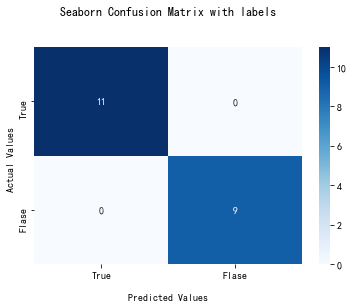

In [10]:
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['True','Flase'])
ax.yaxis.set_ticklabels(['True','Flase'])
plt.show()

分类结果可视化

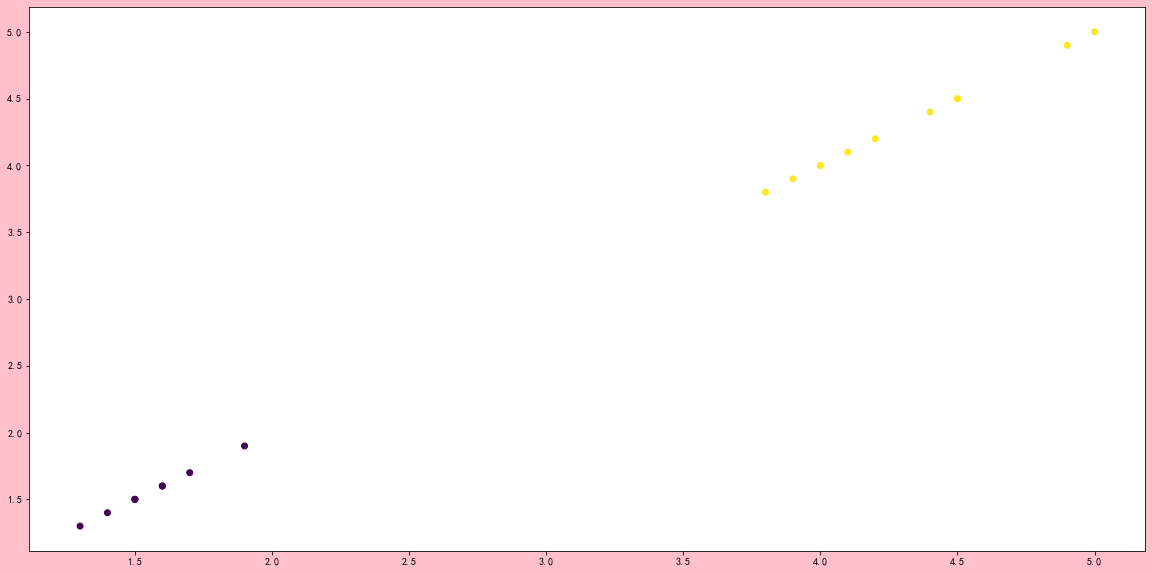

In [11]:
plt.figure(figsize=(20, 10), facecolor='pink')
plt.scatter(x_test[:, 0], x_test[:, 0], c=y_pre)
plt.show()

以上为二分类模型, 但是原数据为多分类模型, 这是可以采取两种策略. 
1. 使用拆解法, 将多分类任务拆为若干个二分类任务求解; 
2. 改进逻辑回归算法, 即将原算法中的Logistic函数进行替换, 并做出相应改进. 
这里采用第一种方法, 拆解法(参考周志华老师的《机器学习》$p_{63}$). 

因为本例中样本只有三个类别, 固采用一对余(One vs. Rest, 简称 OvR)拆解法. 

每次将一个类的样例作为正例、所有其他类的样例作为反例来 训练3个分类器.
- 在测试时若仅有一个分类器预测为正类，则对应的类别标记作为最终分类结果;
- 若有多个分类器预测为正类, 则考虑各分类器的预测置信度(这里将各分类器在训练集上的准确度作为置信度)，选择置信度最大的类别标记作为分类结果;
- 若所有分类器均预测为反类, 则选择置信度最小的类别标记作为分类结果. 

In [12]:
classes = data["y"].unique().tolist()

data_c = copy.copy(data)
x = data_c[["x1", "x2"]].values
y = data_c["y"].values
x_train, x_test, y_train_pri, y_test = train_test_split(x, y, test_size=0.2, random_state=23)

lrs = {} # 3个分类器的字典, 将每个分类器和置信度按键值对的形式存入字典

for cls in classes:
    y_train = copy.copy(y_train_pri)
    y_train[y_train != cls] = -1
    y_train[y_train == cls] = 1
    lr = Logistic_regression()
    lr.fit(x_train, y_train)
    y_pre = lr.predict(x_train)
    lrs[lr] = accuracy_score(y_train, y_pre)

<ipython-input-3-d902ddf95dbf>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
<ipython-input-3-d902ddf95dbf>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
<ipython-input-3-d902ddf95dbf>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


矩阵y_test_pre表示各个分类器在测试集样本上的结果, 每一行表示一个测试集样本, 每一列表示一个分类器的预测结果

In [13]:
y_test_pre = []
for key, value in lrs.items():
    y_test_pre.append(key.predict(x_test).tolist())
y_test_pre = np.array(y_test_pre).T
y_test_pre

<ipython-input-3-d902ddf95dbf>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


array([[-1.,  1.,  1.],
       [-1.,  1.,  1.],
       [-1.,  1., -1.],
       [ 1.,  1., -1.],
       [-1.,  1.,  1.],
       [-1.,  1., -1.],
       [ 1.,  1., -1.],
       [-1.,  1.,  1.],
       [ 1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.],
       [ 1.,  1., -1.],
       [-1.,  1.,  1.],
       [ 1.,  1., -1.],
       [ 1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1.,  1.],
       [ 1.,  1., -1.],
       [-1.,  1.,  1.],
       [ 1.,  1., -1.],
       [ 1.,  1., -1.],
       [ 1.,  1., -1.],
       [-1.,  1.,  1.],
       [ 1.,  1., -1.],
       [ 1.,  1., -1.],
       [-1.,  1.,  1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.]])

按照OvR拆解法进行预测

In [14]:
y_pre = []
for row in y_test_pre:
    t = 0
    weight = 0
    if np.all(row == -1):
        t = list(lrs.values()).index(min(lrs.values()))
    for j in range(len(row)):
        if row[j] == -1:
            continue
        elif list(lrs.values())[j]>=weight:
            t = j
            weight = list(lrs.values())[j]
        else:
            continue
    y_pre.append(t)
y_pre

[2,
 2,
 1,
 0,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 1]

观察分类后的结果, 并计算分类后的精确度, 召回率等指标, 如下:

In [15]:
accuracy_score(y_test, y_pre)

0.9666666666666667

In [16]:
print(classification_report(y_test, y_pre))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.89      1.00      0.94         8
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



画出混淆矩阵并可视化.

In [17]:
cm = confusion_matrix(y_test, y_pre, labels=[0, 1, 2])
print(cm)

[[12  0  0]
 [ 0  8  0]
 [ 0  1  9]]


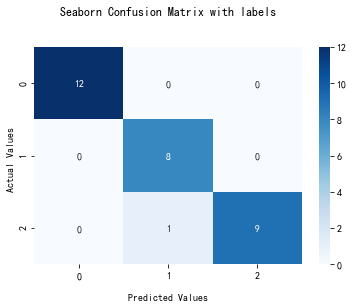

In [18]:
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels([0, 1, 2])
ax.yaxis.set_ticklabels([0, 1, 2])
plt.show()

分类结果可视化

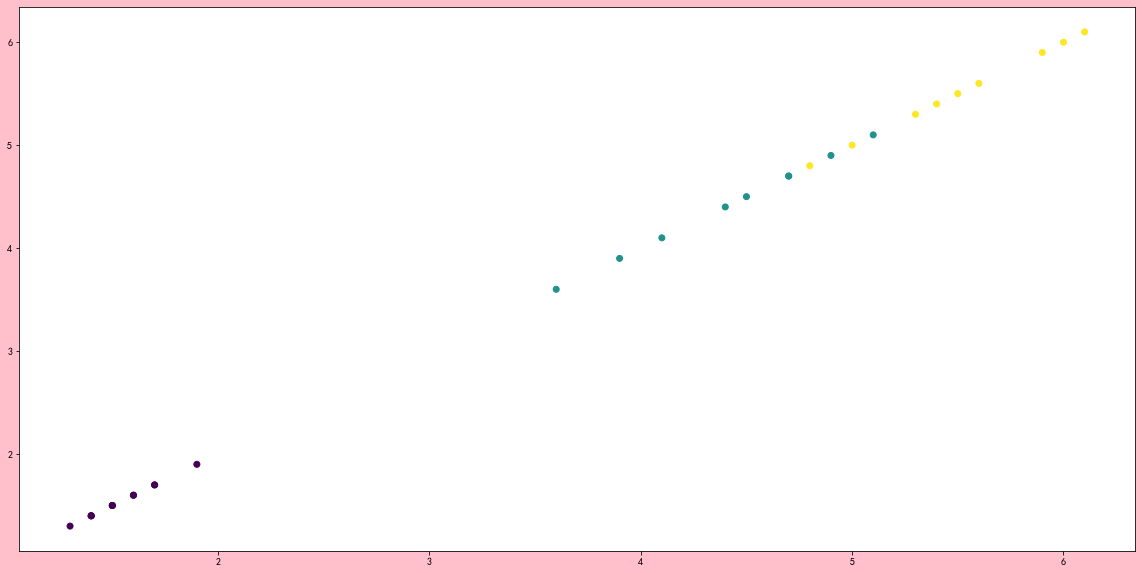

In [19]:
plt.figure(figsize=(20, 10), facecolor='pink')
plt.scatter(x_test[:, 0], x_test[:, 0], c=y_pre)
plt.show()